In [1]:
## import

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from enum import Enum
from math import exp, pi, sqrt
from sklearn.neighbors import NearestNeighbors
from abc import ABC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import optuna
from sklearn.neighbors import KNeighborsClassifier


In [2]:
df = pd.read_csv("WineQT.csv")
df.drop("Id", axis=1, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


## Normalization


In [3]:
df.dropna()
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
df['total sulfur dioxide']=df['total sulfur dioxide'].apply(np.log)
df['chlorides']=df['chlorides'].apply(np.log)
df['residual sugar']=df['residual sugar'].apply(np.log)

<Axes: xlabel='quality', ylabel='count'>

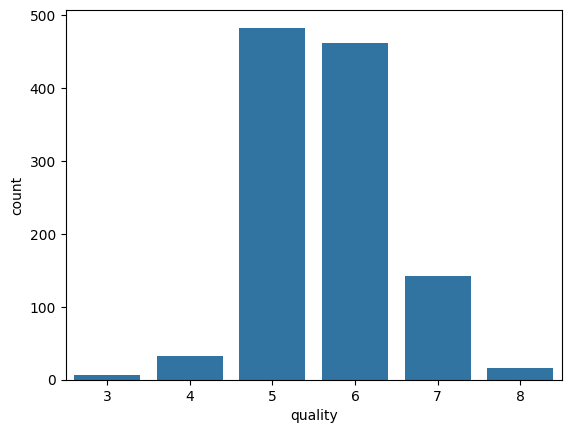

In [5]:
sns.countplot(x=df['quality'])

<Axes: xlabel='quality', ylabel='count'>

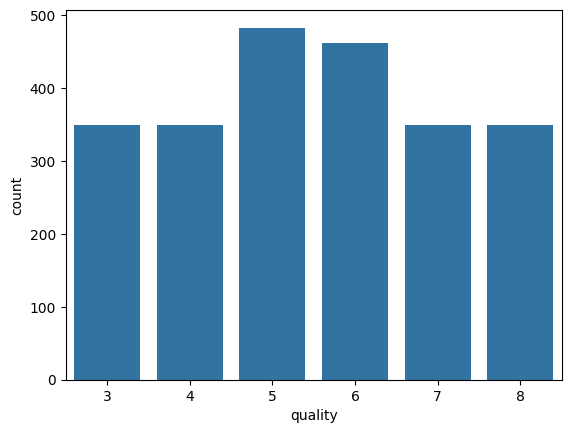

In [6]:
X=df.drop(['quality'],axis=1)
y=df['quality']

strategy={3:350, 4:350,7:350,8:350}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X, y)
sns.countplot(x=y)

In [7]:
scaler = StandardScaler()
data = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=30)

## Model

#### Kernels


In [8]:
def uniform(x):
    if -1 < x < 1:
        return 0.5
    else:
        return 0

def triangular(x):
    return max(0, 1 - abs(x))

def epanechnikov(x):
    return max(0, 0.75 * (1 - x ** 2))

def gaussian(x):
    return 1 / sqrt(2 * pi) * exp(- (x ** 2 / 2))

In [9]:
class Kernel(Enum):
    UNIFORM = uniform
    TRIANGULAR = triangular
    EPANECHNIKOV = epanechnikov
    GAUSSIAN = gaussian

#### Metrics

In [10]:
class Metrics(Enum):
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    MANHATTAN = 'manhattan'


# NearestNeighbors is supports those metrics and they're being passed via 'metrics' argument

#### WindowType

In [11]:
class WindowType(ABC):
    pass

class Fixed(WindowType):
    
    def __init__(self, h):
        self.h = h

class NotFixed(WindowType):
    
    def __init__(self, n) -> None:
        self.n = n

#### Algorithm

In [37]:
class KNNLab:

    def __init__(
            self, 
            windowType: WindowType,
            metrics: Metrics,
            kernel: Kernel
    ):
        switch = {
            Fixed: self._getFixedWindowTypeInfo,
            NotFixed: self._getNotFixedWindowTypeInfo
        }

        self.windowType = windowType
        self.metrics = metrics
        self.kernel = kernel

        handler = switch.get(type(self.windowType))
        if handler:
            handler()
        else:
            raise RuntimeError("Unknown Window type argument")
        
    def _getFixedWindowTypeInfo(self):
        self.n_neighbors = self.windowType.h
        self.divisor = lambda _: self.n_neighbors
    
    def _getNotFixedWindowTypeInfo(self):
        self.n_neighbors = self.windowType.n + 1
        self.divisor = lambda x: x[-1]
    

    def fit(self, x, y, weights = None):
        self.x = x
        self.y = y
        if weights == None:
            self.weights = np.ones(len(x))
        else:
            self.weights = weights
        self.class_count = self.y.max()
        return self
    
    def predict(self, x):
        predictions = []

        for dist, claz, weight in zip(*self._prepareInfo(x)):
            grade = [0 for _ in range(self.class_count + 1)]
            for distance, clazz, w in zip(dist[:-1], claz, weight):
                grade[clazz] += self.kernel(distance / self.divisor(dist)) * w
            predictions.append(grade.index(max(grade)))

        return predictions
        



    def _prepareInfo(self, x):
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metrics.value)
        nn.fit(self.x)
        dist, ind = nn.kneighbors(x, n_neighbors=self.n_neighbors)
        clazz = [(self.y.iloc[i]).to_list() for i in ind]
        weights = [[self.weights[j] for j in i] for i in ind]
        return (dist, clazz, weights)




In [13]:
a = KNNLab(NotFixed(2), Metrics.MANHATTAN, Kernel.TRIANGULAR)

my_a = a.fit(X_train, y_train)
pred = my_a.predict(X_test)

C:\Users\sasha\AppData\Local\Temp\ipykernel_24536\3510837034.py:46: RuntimeWarning: invalid value encountered in scalar divide
  grade[clazz] += self.kernel(distance / self.divisor(dist)) * w


In [14]:
def accuracy(y_real, y_expected):
    correct = sum(1 for real, expected in zip(y_real, y_expected) if real == expected)
    return correct / len(y_real) * 100


accuracy(y_test.to_list(), pred)

80.11363636363636

# Optimize

In [15]:
X_tr, X_val, y_tr, y_val = train_test_split(data, y, test_size=0.15, random_state=30)

In [16]:
def objective(windowType, trial):
    if windowType == 'fixed':
        h = trial.suggest_int("h", 1, 30)
    else:
        k = trial.suggest_int("k", 1, 200)
    kernel = trial.suggest_categorical("Kernel", [Kernel.UNIFORM, Kernel.TRIANGULAR, Kernel.EPANECHNIKOV, Kernel.GAUSSIAN])
    metrics = trial.suggest_categorical("Metrics", [Metrics.MANHATTAN, Metrics.EUCLIDEAN, Metrics.COSINE])

    model = KNNLab(Fixed(h), metrics, kernel) if windowType == 'fixed' \
       else KNNLab(NotFixed(k), metrics, kernel)
    
    pred = model.fit(X_tr, y_tr).predict(X_val)
    return accuracy(y_val.to_list(), pred)


objective_fixed = lambda trial: objective('fixed', trial)
objective_not_fixed = lambda trial: objective('notfixed', trial)


In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_fixed, n_trials=100)
best_fixed = study.best_trial

[I 2024-03-31 00:13:48,976] A new study created in memory with name: no-name-60aa46d9-eb59-412b-a119-6120f8ce6c10
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function uniform at 0x0000012752119120> which is of type function.
  warnings.warn(message)
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function triangular at 0x00000127521192D0> which is of type function.
  warnings.warn(message)
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for per

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_not_fixed, n_trials=100)
best_not_fixed = study.best_trial

[I 2024-03-31 00:13:53,486] A new study created in memory with name: no-name-e6dde1d9-c47a-49ac-af65-53bbec412718
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function uniform at 0x0000012752119120> which is of type function.
  warnings.warn(message)
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function triangular at 0x00000127521192D0> which is of type function.
  warnings.warn(message)
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for per

In [19]:
def print_result(trial):
    print('Best trial:')
    print('  Value: ', trial.value)
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

In [20]:
print_result(best_fixed)
print()
print_result(best_not_fixed)

Best trial:
  Value:  80.68181818181817
  Params: 
    h: 3
    Kernel: <function epanechnikov at 0x0000012752118700>
    Metrics: Metrics.EUCLIDEAN

Best trial:
  Value:  81.5340909090909
  Params: 
    k: 6
    Kernel: <function triangular at 0x00000127521192D0>
    Metrics: Metrics.EUCLIDEAN


#### Optimize lib

In [21]:
def lib_objective(trial):
    metrics = trial.suggest_categorical("Metrics", ['euclidean', 'cosine', 'manhattan'])
    n_neib = trial.suggest_int('neighbors', 1, 200)
    model = KNeighborsClassifier(n_neighbors=n_neib, metric=metrics)
    pred = model.fit(X_tr, y_tr).predict(X_val)

    return accuracy(y_val.to_list(), pred)

study = optuna.create_study(direction="maximize")
study.optimize(lib_objective, n_trials=200)
best_lib = study.best_trial

[I 2024-03-31 00:13:59,690] A new study created in memory with name: no-name-2d3e2864-d572-417c-a1fd-8d778cf3ceb1
[I 2024-03-31 00:13:59,730] Trial 0 finished with value: 47.159090909090914 and parameters: {'Metrics': 'cosine', 'neighbors': 143}. Best is trial 0 with value: 47.159090909090914.
[I 2024-03-31 00:13:59,771] Trial 1 finished with value: 50.28409090909091 and parameters: {'Metrics': 'euclidean', 'neighbors': 85}. Best is trial 1 with value: 50.28409090909091.
[I 2024-03-31 00:13:59,800] Trial 2 finished with value: 47.44318181818182 and parameters: {'Metrics': 'cosine', 'neighbors': 154}. Best is trial 1 with value: 50.28409090909091.
[I 2024-03-31 00:13:59,834] Trial 3 finished with value: 50.28409090909091 and parameters: {'Metrics': 'manhattan', 'neighbors': 79}. Best is trial 1 with value: 50.28409090909091.
[I 2024-03-31 00:13:59,862] Trial 4 finished with value: 48.29545454545455 and parameters: {'Metrics': 'cosine', 'neighbors': 129}. Best is trial 1 with value: 50.2

In [22]:
print_result(best_lib)

Best trial:
  Value:  80.68181818181817
  Params: 
    Metrics: euclidean
    neighbors: 1


# Графики

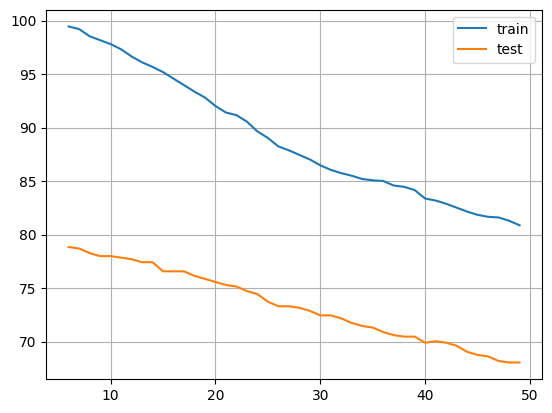

In [30]:
number_of_neighbours = []
grade_test = []
grade_train = []


for i in range(6, 50):
    model = KNNLab(NotFixed(i), Metrics.EUCLIDEAN, Kernel.TRIANGULAR)
    pred_test = model.fit(X_train, y_train).predict(X_test)
    pred_train = model.fit(X_train, y_train).predict(X_train)
    grade_test.append(accuracy(y_test, pred_test))
    grade_train.append(accuracy(y_train, pred_train))
    number_of_neighbours.append(i)


plt.plot(number_of_neighbours, grade_train)
plt.plot(number_of_neighbours, grade_test)
plt.grid(True)
plt.legend(['train', 'test'])
plt.show()   

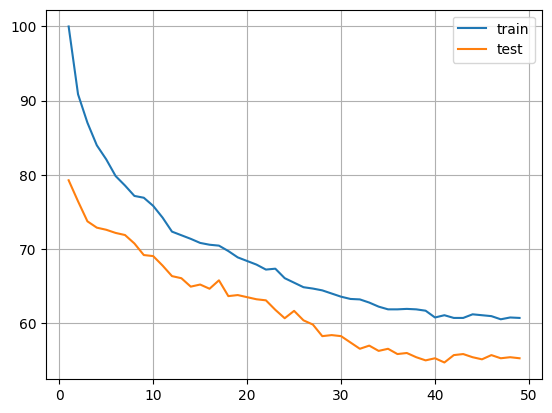

In [27]:
number_of_neighbours = []
grade_test = []
grade_train = []


for i in range(1, 50):
    model = KNeighborsClassifier(metric='euclidean', n_neighbors=i)
    pred_test = model.fit(X_train, y_train).predict(X_test)
    pred_train = model.fit(X_train, y_train).predict(X_train)
    grade_test.append(accuracy(y_test, pred_test))
    grade_train.append(accuracy(y_train, pred_train))
    number_of_neighbours.append(i)


plt.plot(number_of_neighbours, grade_train)
plt.plot(number_of_neighbours, grade_test)
plt.grid(True)
plt.legend(['train', 'test'])
plt.show()   

# LOWESS (как я понял)

In [25]:
def lowess(X, Y):
    model = KNNLab(NotFixed(6), Metrics.EUCLIDEAN, Kernel.TRIANGULAR)
    anomalies = []

    for i in range(len(X)):
        X_train_without_i = np.delete(X,i, axis=0)
        Y_train_without_i = Y.drop(Y.index[i], inplace=False)
        tmp = model.fit(X_train_without_i, Y_train_without_i)
        pred = tmp.predict(np.array([X[i]]))
        if abs(pred[0] - Y[Y.index[i]]) > 1:
            anomalies.append(i)
    
    return anomalies

# anon = lowess(X_train, y_train)

#### функция для составления новых весов

In [34]:
def get_new_weights(weight, anomalies):
    new_weights = []
    for i in range(len(X_train)):
        if i in anomalies:
            new_weights.append(weight)
        else:
            new_weights.append(1)
    return new_weights

### Подбор новых весов

In [35]:
def apply_new_weights(weight, anomalies):
    weights = get_new_weights(weight, anomalies)

    model = KNNLab(NotFixed(6), Metrics.EUCLIDEAN, Kernel.TRIANGULAR)
    pred = model.fit(X_train, y_train, weights).predict(X_test)

    return accuracy(y_test, pred)

New best prediction accuracy: 79.26136363636364



Text(0, 0.5, 'Accuracy')

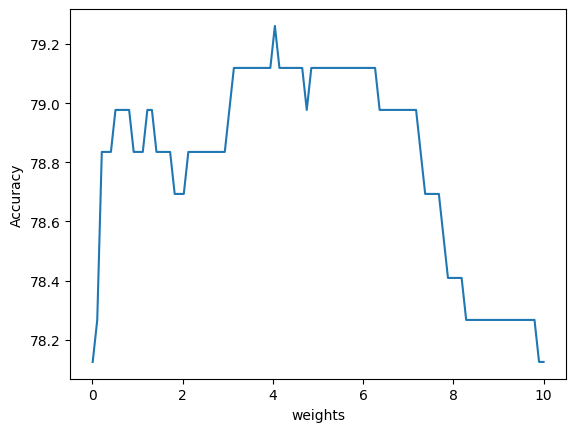

In [38]:
anomalies = lowess(X_train, y_train)
weights = np.linspace(0.01, 10, 100)
results = [apply_new_weights(w, anomalies) for w in weights]

print(f'New best prediction accuracy: {max(results)}\n')
plt.plot(weights, results)
plt.xlabel('weights')
plt.ylabel('Accuracy')